In [30]:
from openbabel import pybel
import os
import re
import argparse
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.rdMolAlign import AlignMol
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
import copy
from openbabel import openbabel as ob

In [3]:
directory = "/home/jpam/Dropbox/eduardo/3D1/"

In [59]:
ref = Chem.MolFromPDBFile(os.path.join(directory,"conferir_coordenadas/5HT2A_9o_original.pdb"))

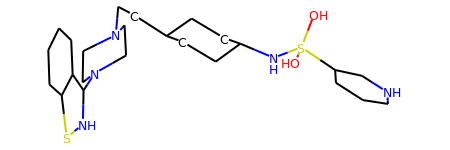

In [60]:
ref

In [61]:
rdmol = Chem.MolFromMol2File(os.path.join(directory,"conjunto_treinamento_allana","resultados","5HT2A_9o.mol2"))

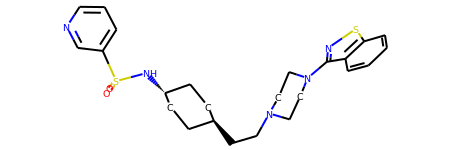

In [62]:
rdmol

In [63]:
rdmols = [ref,rdmol]

In [64]:
from rdkit.Chem import rdFMCS
res=rdFMCS.FindMCS(rdmols)
res

In [50]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [51]:
# Prepare molecules labeling atoms with numbers and generating 2D depictions
for m in rdmols:
    mol_with_atom_index(m)
    AllChem.Compute2DCoords(m)

In [52]:
smartsString = res.smartsString
smartsString

'[#6]1-[#6](-[#6]-[#6]-[#6](-[#6]-1)-[#7]-[#16]-[#6]1-,:[#6]-,:[#6]-,:[#6]-,:[#7]-,:[#6]-,:1)-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1-,:[#7]-,:[#16]-,:[#6]2-,:[#6]-,:1-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:2'

In [65]:
common_atoms = [m.GetSubstructMatch(Chem.MolFromSmarts(smartsString)) for m in rdmols]

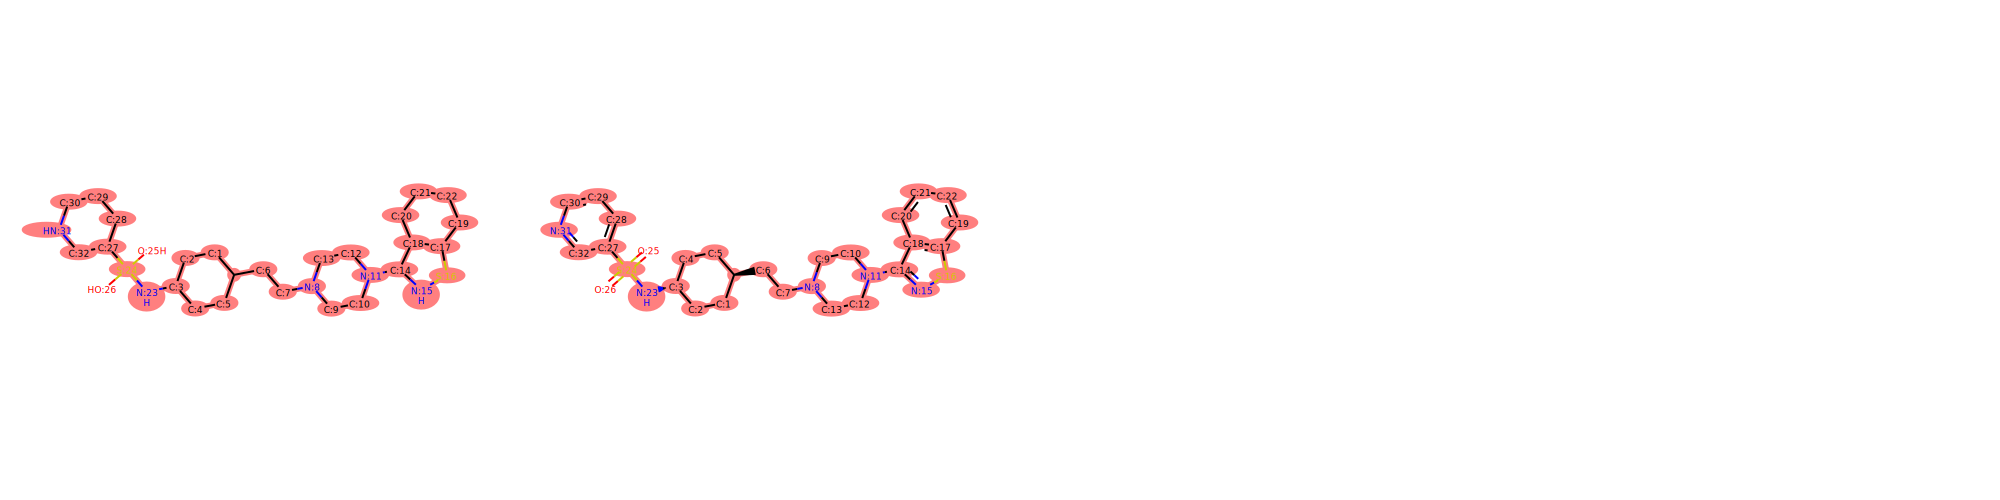

In [54]:
# core = Chem.MolFromSmiles( 'c1ncc2nc[nH]c2n1' )
DrawingOptions.includeAtomNumbers=True
img = Draw.MolsToGridImage(rdmols, 
                           molsPerRow=4, 
                           useSVG=True,subImgSize=(500, 500), 
#                            legends=[m.title for m in mols],
                           highlightAtomLists = common_atoms,
                           maxMols=110,
                          )
img

In [19]:
molAtoms = [int(a)-1 for a in [15,16,17,19,21,24,23,22,20]]

In [20]:
refAtoms = [int(a)-1 for a in [16,17,18,20,23,22,21,19,15]]

In [55]:
patt = Chem.MolFromSmarts(smartsString)

In [66]:
# alinhamento = AlignMol(rdmol,ref,atomMap=list(zip(molAtoms,refAtoms)))
alinhamento = AlignMol(rdmol,ref,atomMap=list(zip(rdmol.GetSubstructMatch(patt),ref.GetSubstructMatch(patt))))

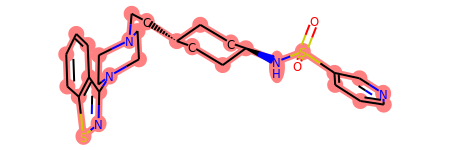

In [67]:
rdmol

In [68]:
Chem.MolToPDBFile(rdmol,os.path.join(directory,"conferir_coordenadas","alinhada.pdb"))

In [70]:
mol = pybel.readstring('pdb',Chem.MolToPDBBlock(rdmol))

In [71]:
mol.addh()

In [74]:
mol.write('mol2',os.path.join(directory,"conferir_coordenadas","alinhada.mol2"))

In [7]:
refMol = rdmols[0]
mols_aligned = [pybel.readstring("mol",Chem.MolToMolBlock(refMol))]
for i,prbMol in enumerate(rdmols[1:]):
    prbAtoms = [int(a)-1 for a in df[1][i+1].split(',')]
    alinhamento = AlignMol(prbMol,refMol,atomMap=list(zip(prbAtoms,refAtoms)))
    mols_aligned.append(pybel.readstring("mol",Chem.MolToMolBlock(prbMol)))


In [10]:
for i,(m1,m2) in enumerate(zip(mols_aligned,mols)):
    for (a1,a2) in zip(m1,m2):
        print(a1,a2)
        a1.partialcharge = a2.partialcharge
    m1.write("mol2",files[i][:-4]+"_aligned.mol2",True)

In [ ]:
obConversion = ob.OBConversion()

In [ ]:
obConversion.SetInAndOutFormats("g09","mol2")

In [ ]:
obmols = []
for i in range(len(files)):
    obmol = ob.OBMol()
    obConversion.ReadFile(obmol, os.path.join(directory,df.iloc[i,0]+".log"))
    obmols.append(obmol)

In [ ]:
os.path.basename(obmols[0].GetTitle())

In [ ]:
for at in ob.OBMolAtomIter(obmols[0]):
    print(at.GetPartialCharge())

In [ ]:
for m1,m2 in zip(mols_aligned,obmols):
    for (a1,a2) in zip(ob.OBMolAtomIter(m1.OBMol),ob.OBMolAtomIter(m2)):
#         a1.partialcharge = a2.partialcharge
        a1.SetPartialCharge(a2.GetPartialCharge())
    m1.write("mol2",m1.title[:-4]+"_aligned.mol2",True)

In [ ]:
obmols[0].GetTitle()

In [ ]:
m1.title